In [1]:
# import libraries 
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

## Load In Dataset

In [2]:
sd_listings = pd.read_csv('data/sd_listings', index_col= 0)
sd_listings.head(3)

,id,listing_url,latitude,longitude,zipcode,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,nightly_price,price_per_stay,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,host_id,host_url,host_since,host_about,host_response_time,host_response_rate,host_is_superhost,neighbourhood_cleansed,host_total_listings_count,host_has_profile_pic,host_identity_verified,number_of_reviews,number_of_stays,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,33159143,https://www.airbnb.com/rooms/33159143,32.91736,-117.07635,92131.0,"PRIVATE ROOM, SAFE NEIGHBORHOOD IN SCRIPPS RANCH",80% of the house + yourCozy room ... in Scripp...,"Full bed, private bath...",80% of the house + yourCozy room ... in Scripp...,The neighborhood is a typical Southern Califor...,Have alarm system if you choose to use... I wi...,You can park in the drive way or plenty of spa...,"Kitchen, Dining room, Living room, Very Comfor...","I lived in San Diego 40+ years, love to share ...",#NAME?,House,Private room,1,1.0,1.0,1.0,Real Bed,"{Wifi,Kitchen,""Free parking on premises"",Heati...",1100.0,1100.0,1000.0,0.0,1.0,0.0,60.0,90.0,249661563.0,https://www.airbnb.com/users/show/249661563,3/18/19,Retired businessman of 30 years in this commun...,within a few hours,100.0,0.0,Scripps Ranch,1.0,1.0,0.0,0.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,1.0,0.0,strict_14_with_grace_period,0.0,0.0
1,17138468,https://www.airbnb.com/rooms/17138468,32.84067,-117.27443,92037.0,NOT AVAILABLE,AVAILABLE ONLY IN WINTER PRIME La Jolla Villag...,NaN,AVAILABLE ONLY IN WINTER PRIME La Jolla Villag...,NaN,NaN,NaN,NaN,NaN,NaN,Apartment,Entire home/apt,1,2.0,2.0,3.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",1400.0,1400.0,NaN,NaN,1.0,0.0,30.0,1125.0,79755951.0,https://www.airbnb.com/users/show/79755951,6/24/16,Quiet and considerate.,NaN,0.0,0.0,La Jolla,1.0,1.0,0.0,2.0,4.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,1.0,0.0,strict_14_with_grace_period,0.0,0.0
2,21898446,https://www.airbnb.com/rooms/21898446,32.79797,-117.2425,92109.0,Townhome in Pacific Beach,Hi! We are basically renting this master for a...,NaN,Hi! We are basically renting this master for a...,NaN,NaN,NaN,NaN,NaN,NaN,Townhouse,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",""P...",1250.0,1250.0,NaN,NaN,1.0,0.0,30.0,30.0,159773487.0,https://www.airbnb.com/users/show/159773487,11/22/17,NaN,NaN,0.0,0.0,Pacific Beach,1.0,1.0,0.0,0.0,0.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,1.0,0.0,flexible,0.0,0.0


## Select columns for modeling

In [3]:
sd_listings.columns

Index(['id', 'listing_url', 'latitude', 'longitude', 'zipcode', 'name',
       'summary', 'space', 'description', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'nightly_price', 'price_per_stay',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'host_id', 'host_url', 'host_since',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'neighbourhood_cleansed',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'number_of_reviews', 'number_of_stays',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license',

In [4]:
modeling_cols = ['id', 'latitude', 'longitude', 'neighbourhood_cleansed',
               'zipcode', 'property_type', 'room_type', 'accommodates', 
               'bathrooms', 'bedrooms', 'beds',
               'bed_type','nightly_price', 'price_per_stay',
               'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
               'minimum_nights', 'maximum_nights','host_response_time', 'host_response_rate',
               'host_is_superhost', 'host_total_listings_count', 'host_has_profile_pic',
               'host_identity_verified', 'number_of_reviews', 'number_of_stays',
               'review_scores_rating', 'review_scores_accuracy',
               'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location',
               'review_scores_value', 'requires_license', 'instant_bookable',
               'is_business_travel_ready', 'cancellation_policy',
               'require_guest_profile_picture', 'require_guest_phone_verification']

In [5]:
sd_modeling = sd_listings[modeling_cols]
sd_modeling.tail(2)

,id,latitude,longitude,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,nightly_price,price_per_stay,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,number_of_reviews,number_of_stays,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
13049,17975942,32.83598,-117.27878,La Jolla,92037.0,House,Entire home/apt,21,5.5,7.0,13.0,Real Bed,1305.0,1305.0,1000.0,800.0,21.0,0.0,1.0,1125.0,within an hour,99.0,0.0,403.0,1.0,0.0,4.0,8.0,80.0,9.0,8.0,10.0,8.0,10.0,9.0,0.0,1.0,0.0,super_strict_60,0.0,0.0
13050,33160513,32.74357,-117.17679,Midtown,92103.0,Condominium,Entire home/apt,24,8.0,8.0,10.0,Real Bed,398.0,398.0,500.0,499.0,24.0,0.0,1.0,365.0,within an hour,100.0,1.0,123.0,1.0,0.0,1.0,2.0,80.0,10.0,10.0,6.0,10.0,10.0,8.0,0.0,1.0,0.0,super_strict_60,0.0,0.0


## Handle remaining missing values

In [6]:
# check missing
sd_modeling.isna().sum()

id                                     0
latitude                               0
longitude                              0
neighbourhood_cleansed                 2
zipcode                                0
property_type                          0
room_type                              0
accommodates                           0
bathrooms                              3
bedrooms                               3
beds                                   9
bed_type                               0
nightly_price                          1
price_per_stay                         1
security_deposit                    2675
cleaning_fee                        1505
guests_included                        1
extra_people                           1
minimum_nights                         1
maximum_nights                         1
host_response_time                  2146
host_response_rate                     2
host_is_superhost                      2
host_total_listings_count              7
host_has_profile

### Imputing missing `beds`

In [7]:
# fill missing beds with values in bedrooms
sd_modeling['beds'] = sd_modeling['beds'].fillna(sd_modeling['bedrooms'])

### Fill in missing `security_deposit`, `cleaning_fee` with 0's

In [8]:
sd_modeling[['security_deposit', 'cleaning_fee']] = sd_modeling[['security_deposit', 'cleaning_fee']].fillna(0)

### Impute missing values in `host_response_time`

In [9]:
# assign a new value 'no response' for the missing values
sd_modeling['host_response_time'] = sd_modeling['host_response_time'].fillna('no response')

In [10]:
sd_modeling['host_response_time'].value_counts()

within an hour        8410
no response           2146
within a few hours    1587
within a day           762
a few days or more     147
Name: host_response_time, dtype: int64

### Drop remaining rows with missing values
ie. Values that cannot be imputed because of nature of the feature

In [11]:
# Drop rows that has NaN values on selected columns
sd_modeling = sd_modeling.dropna()

In [12]:
sd_modeling.isna().sum()

id                                  0
latitude                            0
longitude                           0
neighbourhood_cleansed              0
zipcode                             0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
beds                                0
bed_type                            0
nightly_price                       0
price_per_stay                      0
security_deposit                    0
cleaning_fee                        0
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
host_response_time                  0
host_response_rate                  0
host_is_superhost                   0
host_total_listings_count           0
host_has_profile_pic                0
host_identity_verified              0
number_of_re

### Check of data-types after cleaning

In [13]:
# convert to appropriate datatype
sd_modeling['bedrooms'] = sd_modeling['bedrooms'].astype(float)
sd_modeling['zipcode'] = sd_modeling['zipcode'].astype(int)
sd_modeling['latitude'] = sd_modeling['latitude'].astype(float)
sd_modeling['longitude'] = sd_modeling['longitude'].astype(float)
sd_modeling['beds'] = sd_modeling['beds'].astype(float).astype(int)
sd_modeling['id'] = sd_modeling['id'].astype(int)

In [14]:
sd_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13039 entries, 0 to 13050
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                13039 non-null  int64  
 1   latitude                          13039 non-null  float64
 2   longitude                         13039 non-null  float64
 3   neighbourhood_cleansed            13039 non-null  object 
 4   zipcode                           13039 non-null  int64  
 5   property_type                     13039 non-null  object 
 6   room_type                         13039 non-null  object 
 7   accommodates                      13039 non-null  int64  
 8   bathrooms                         13039 non-null  float64
 9   bedrooms                          13039 non-null  float64
 10  beds                              13039 non-null  int64  
 11  bed_type                          13039 non-null  object 
 12  nightly_p

In [15]:
sd_modeling.describe()

,id,latitude,longitude,zipcode,accommodates,bathrooms,bedrooms,beds,nightly_price,price_per_stay,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,number_of_reviews,number_of_stays,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification
count,1.303900e+04,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.000000,13039.0,13039.000000,13039.0,13039.000000,13039.000000
mean,2.137590e+07,32.768303,-117.180228,92119.115960,4.467290,1.507976,1.638086,2.384232,223.760948,531.701204,269.598819,95.218038,2.307846,13.541376,4.748140,619.999080,80.840939,0.368587,42.851599,0.998543,0.486234,34.881203,69.762405,95.596672,9.758570,9.655725,9.856891,9.848685,9.822111,9.545364,0.0,0.515070,0.0,0.027379,0.032441
std,1.050725e+07,0.065390,0.064366,7464.077192,3.009442,0.905094,1.194889,1.900844,344.161583,938.535880,485.414417,104.694887,2.323148,27.613084,15.713361,1297.715385,37.332285,0.482440,175.396613,0.038146,0.499830,60.035711,120.071422,6.446881,0.655255,0.741162,0.526121,0.543015,0.519311,0.760059,0.0,0.499792,0.0,0.163193,0.177175
min,6.000000e+00,32.531040,-117.281990,22000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.0,0.000000,0.0,0.000000,0.000000
25%,1.358989e+07,32.725275,-117.244430,92101.000000,2.000000,1.000000,1.000000,1.000000,85.000000,130.000000,0.000000,25.000000,1.000000,0.000000,1.000000,29.000000,91.000000,0.000000,1.000000,1.000000,0.000000,2.000000,4.000000,95.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,0.0,0.000000,0.0,0.000000,0.000000
50%,2.180361e+07,32.757190,-117.167080,92107.000000,4.000000,1.000000,1.000000,2.000000,140.000000,297.000000,100.000000,65.000000,1.000000,0.000000,2.000000,999.000000,100.000000,0.000000,2.000000,1.000000,0.000000,10.000000,20.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,1.000000,0.0,0.000000,0.000000
75%,3.069301e+07,32.798055,-117.140265,92110.000000,6.000000,2.000000,2.000000,3.000000,250.000000,500.000000,400.000000,130.000000,2.000000,20.000000,3.000000,1125.000000,100.000000,1.000000,9.000000,1.000000,1.000000,41.000000,82.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,1.000000,0.0,0.000000,0.000000
max,3.786276e+07,33.086070,-116.926530,921096.000000,24.000000,27.500000,14.000000,25.000000,10000.000000,15000.000000,5000.000000,1025.000000,24.000000,300.000000,800.000000,99999.000000,100.000000,1.000000,1737.000000,1.000000,1.000000,786.000000,1572.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,1.000000,0.0,1.000000,1.000000


In [16]:
sd_modeling[sd_modeling['zipcode']==92307]

,id,latitude,longitude,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,nightly_price,price_per_stay,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,number_of_reviews,number_of_stays,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
12935,34895037,32.88529,-117.24642,Torrey Pines,92307,House,Entire home/apt,16,8.0,8.0,8,Real Bed,1518.0,1518.0,1000.0,924.0,16.0,0.0,1.0,1125.0,within an hour,99.0,0.0,403.0,1.0,0.0,0.0,0.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,1.0,0.0,super_strict_60,0.0,0.0


In [17]:
sd_modeling.tail(3)

,id,latitude,longitude,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,nightly_price,price_per_stay,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,number_of_reviews,number_of_stays,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
13048,4227110,32.79395,-117.23492,Mission Bay,92109,House,Entire home/apt,20,2.0,4.0,10,Real Bed,208.0,208.0,1000.0,332.0,4.0,25.0,1.0,1125.0,within an hour,96.0,0.0,11.0,1.0,1.0,142.0,284.0,92.0,9.0,9.0,9.0,9.0,10.0,8.0,0.0,1.0,0.0,strict_14_with_grace_period,0.0,0.0
13049,17975942,32.83598,-117.27878,La Jolla,92037,House,Entire home/apt,21,5.5,7.0,13,Real Bed,1305.0,1305.0,1000.0,800.0,21.0,0.0,1.0,1125.0,within an hour,99.0,0.0,403.0,1.0,0.0,4.0,8.0,80.0,9.0,8.0,10.0,8.0,10.0,9.0,0.0,1.0,0.0,super_strict_60,0.0,0.0
13050,33160513,32.74357,-117.17679,Midtown,92103,Condominium,Entire home/apt,24,8.0,8.0,10,Real Bed,398.0,398.0,500.0,499.0,24.0,0.0,1.0,365.0,within an hour,100.0,1.0,123.0,1.0,0.0,1.0,2.0,80.0,10.0,10.0,6.0,10.0,10.0,8.0,0.0,1.0,0.0,super_strict_60,0.0,0.0


In [18]:
# save as csv
path = "data/"

sd_modeling.to_csv(path + 'sd_modeling_cleaned')

## Exploring Categorical Features

### Checking value counts for each categorical feature

In [19]:
cat_cols = sd_modeling.select_dtypes(include = ['object']).columns
cat_cols

Index(['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type',
       'host_response_time', 'cancellation_policy'],
      dtype='object')

In [20]:
for col in cat_cols:
    values = sd_modeling[col].value_counts()
    print(values, "\n")

Mission Bay        1589
Pacific Beach      1040
La Jolla            845
East Village        821
North Hills         737
                   ... 
Yosemite Dr           3
Horton Plaza          3
Eastlake Woods        2
Eastlake Trails       1
Thomy Locust Pl       1
Name: neighbourhood_cleansed, Length: 103, dtype: int64 

House                     4569
Apartment                 3391
Condominium               1990
Townhouse                  713
Guesthouse                 481
Guest suite                470
Bungalow                   298
Cottage                    289
Loft                       259
Villa                       88
Serviced apartment          83
Hostel                      72
Camper/RV                   57
Bed and breakfast           48
Other                       39
Resort                      35
Boat                        35
Tiny house                  29
Boutique hotel              26
Hotel                       15
Aparthotel                  12
Tent                       

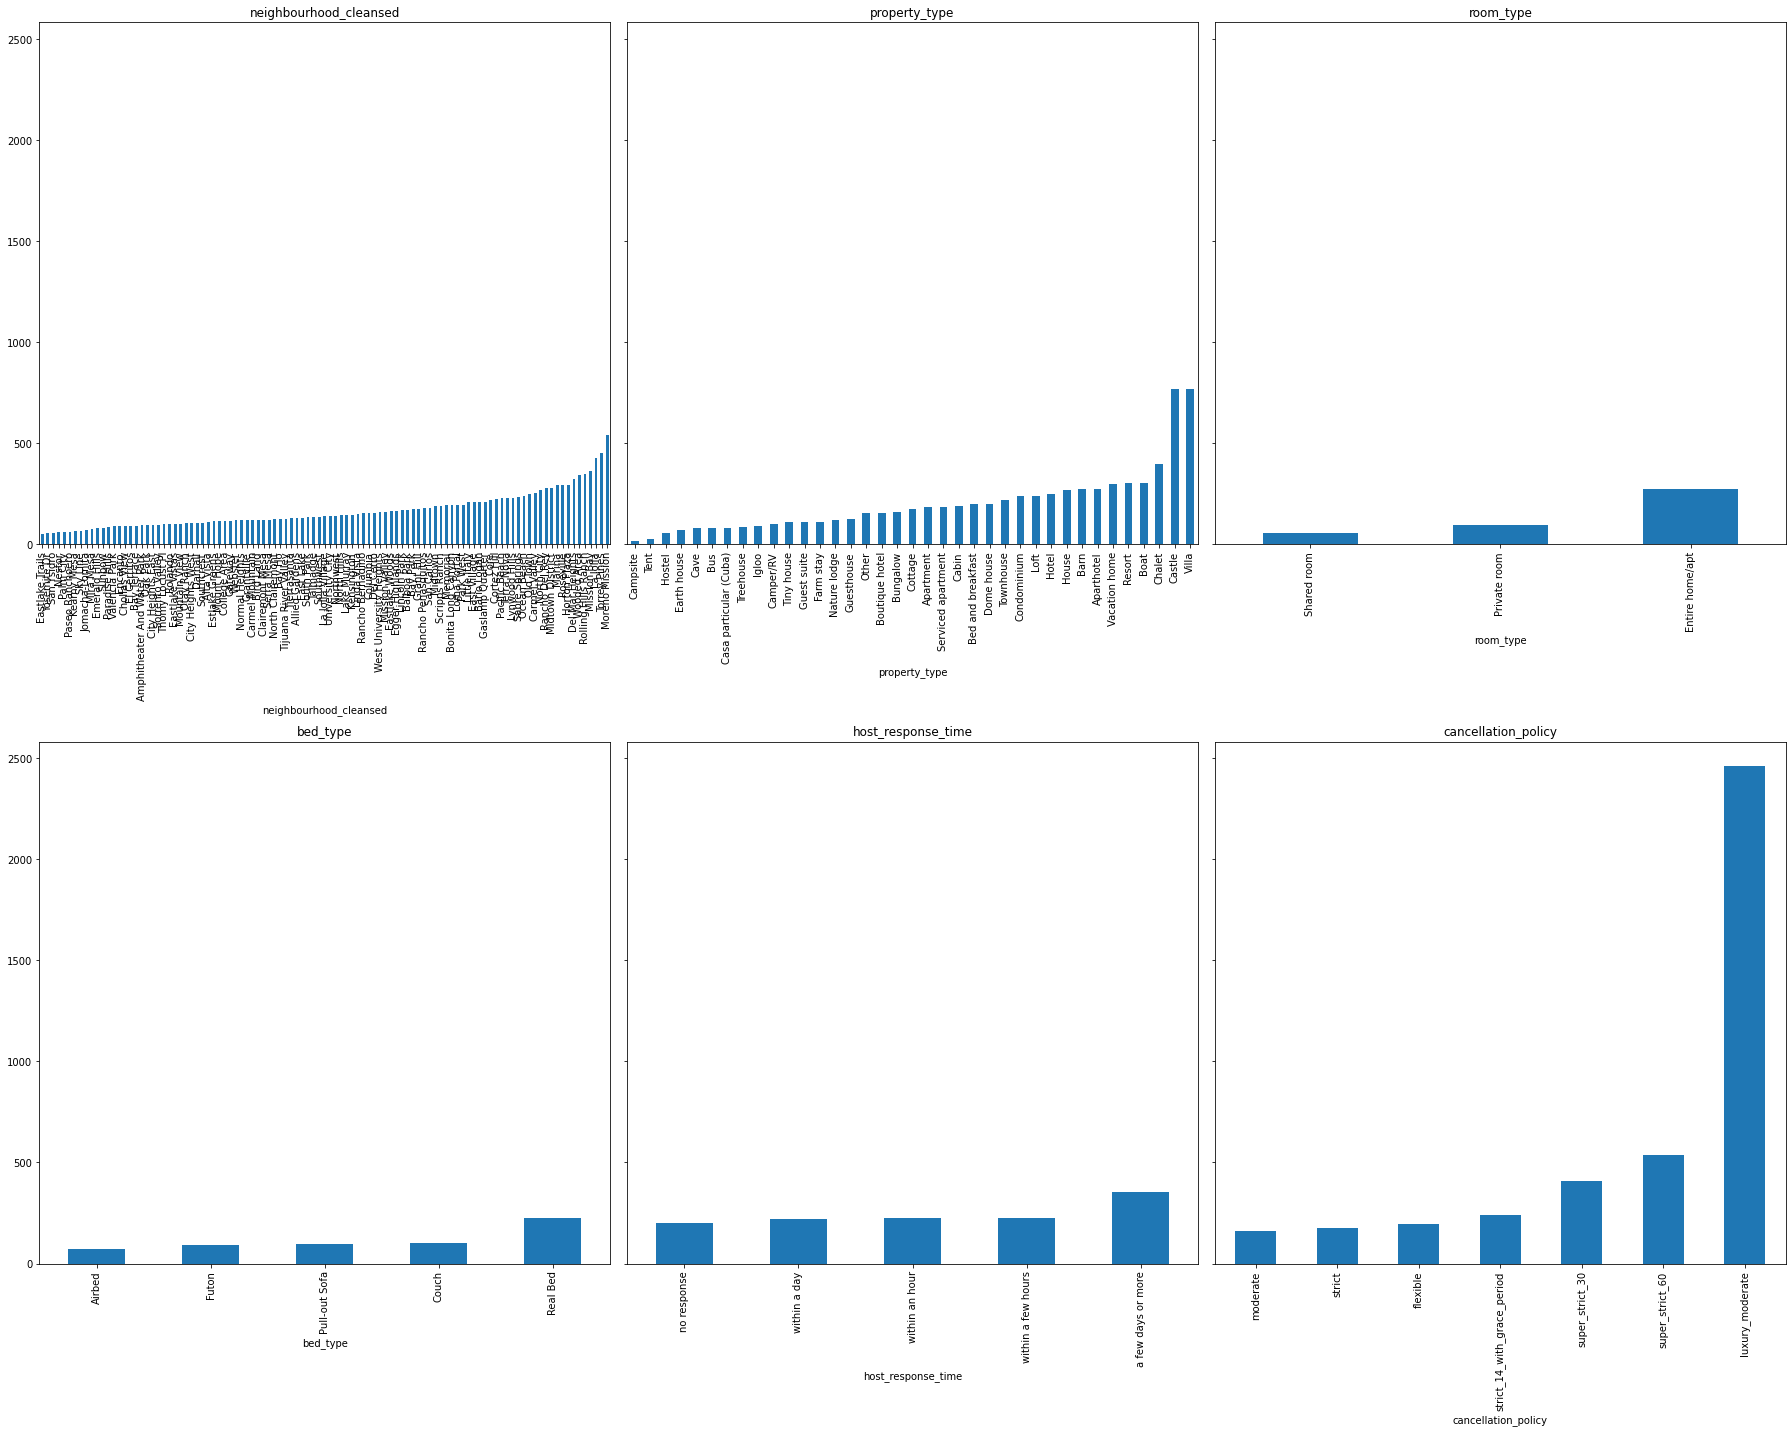

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharey=True)

# Create bar plots
cat_cols = list(cat_cols)

for col, ax in zip(cat_cols, axes.flatten()):
    (sd_modeling.groupby(col)        # group values together by column of interest
         .mean()['nightly_price']    # take the mean of the nightly_price for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()

### Distribution of numerical features

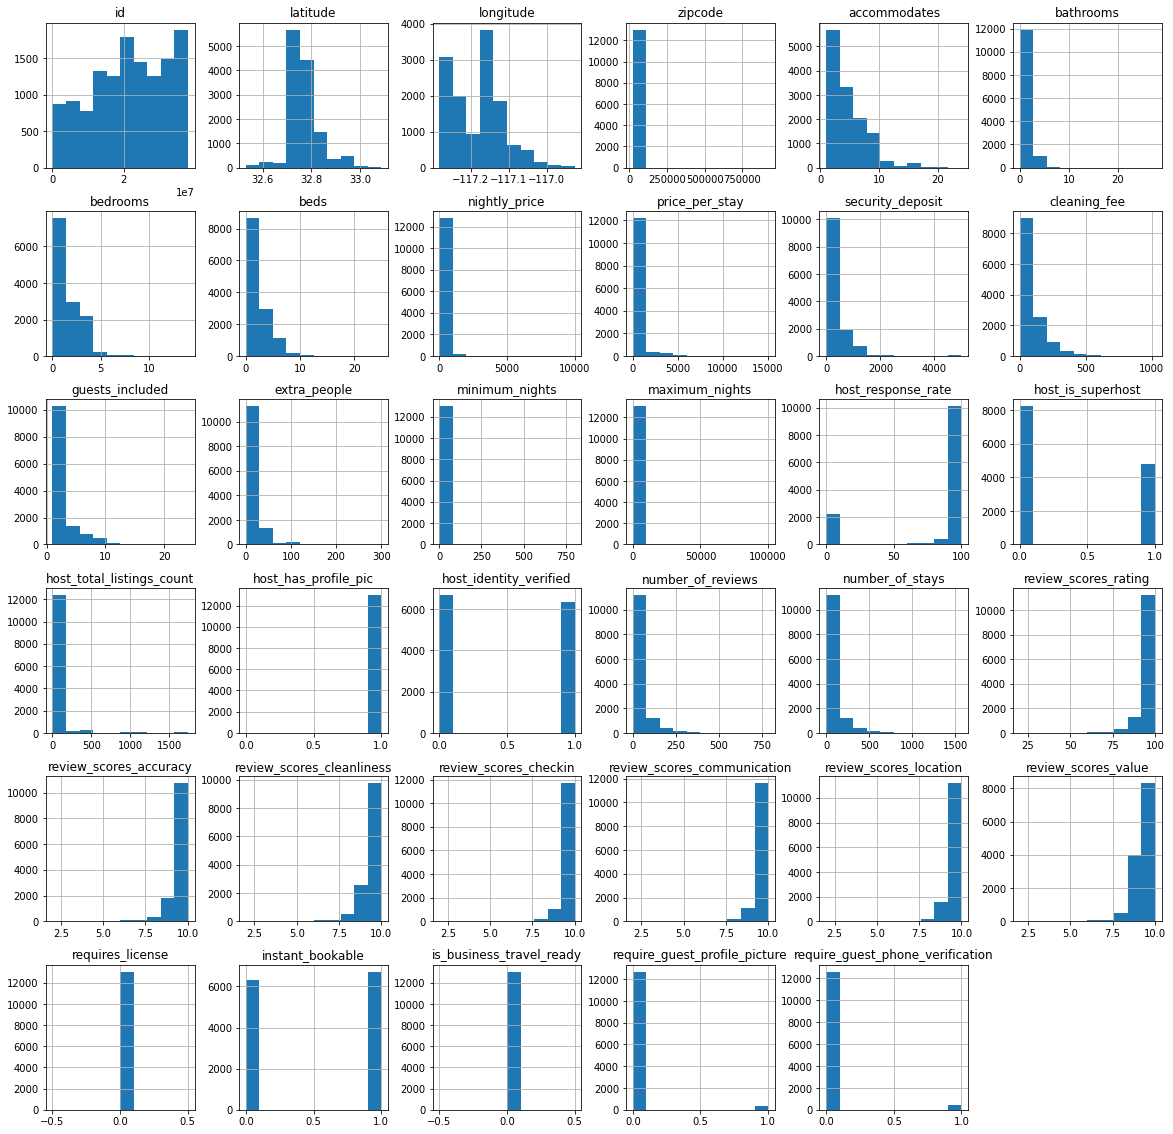

In [22]:
sd_modeling.hist(figsize = (20,20))
plt.show()

- Most numerical features have a long right tail (ie. right-skewed) and are not normally distributed. For example, the number of bedrooms is expected to have a long right tail as most people would likely want to find listings with less than 2 bedrooms. 

## Correlations Between Features

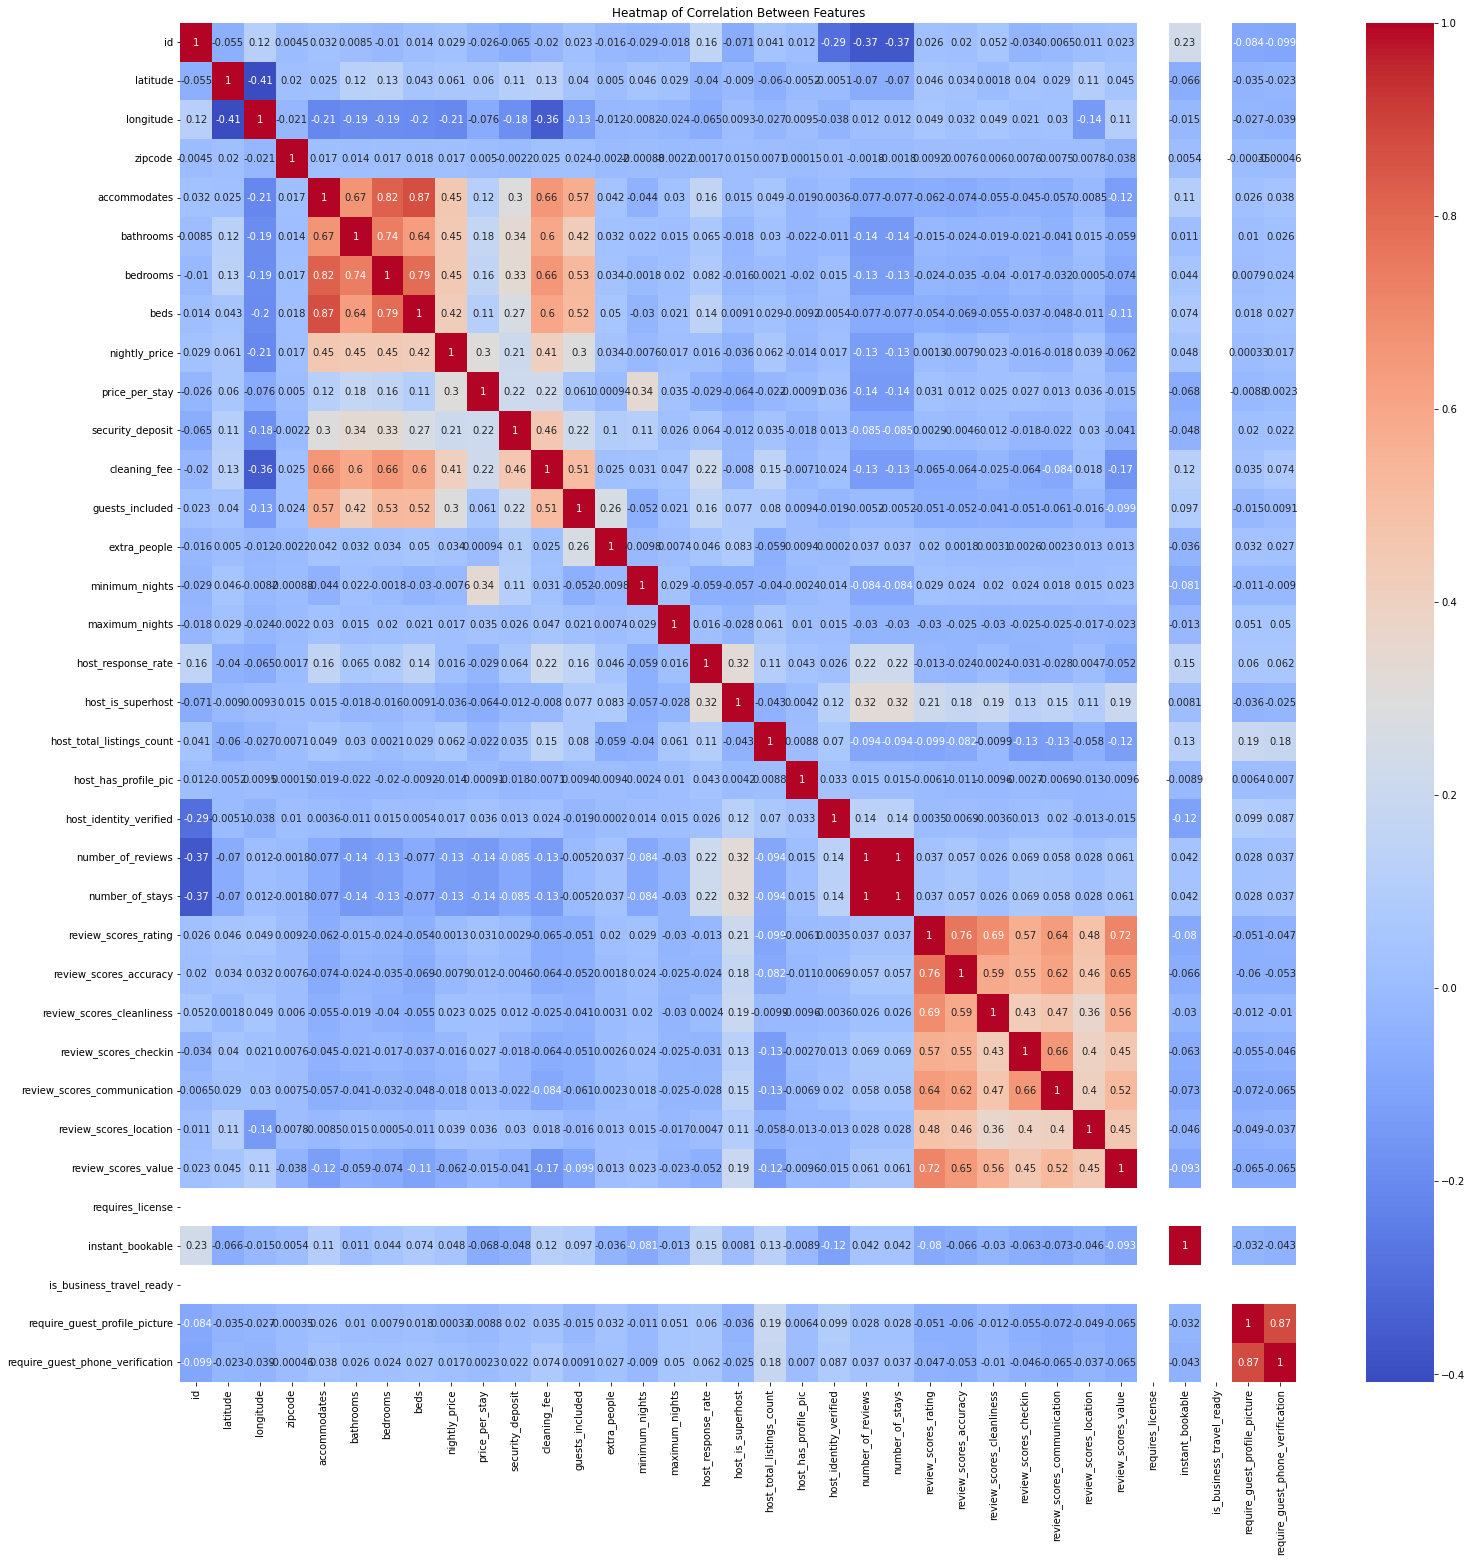

In [23]:
# set up figure size
fig, ax = plt.subplots(figsize=(25, 25))

# set up correlation matrix
corr = sd_modeling.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Features");

plt.show()

- Strong correlational relationship bewteen number of beds, bathrooms, and bedrooms. These features also appear to be the strongest indicators of price ie. nightly price. 


- As expected, there are also correlations between review scores (rating, accuracy, cleanliness, etc.). 

## Preprocessing Features

### Categorical features

In [24]:
cat_cols

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'host_response_time',
 'cancellation_policy']

We'll also add `zipcode` as an nominal feature that needs to be OHE. 

In [25]:
# first convert zipcode to a dtype object for OHE
sd_modeling['zipcode'] = sd_modeling['zipcode'].astype(object)

#### Establish order of ordinal columns

In [26]:
# convert to categorical dtype
sd_modeling['host_response_time'] = sd_modeling['host_response_time'].astype('category')
sd_modeling['cancellation_policy'] = sd_modeling['cancellation_policy'].astype('category')


# define order 
sd_modeling['host_response_time'] = sd_modeling['host_response_time'].cat.reorder_categories(['within an hour',
                                                                                              'within a few hours',
                                                                                              'within a day',
                                                                                              'a few days or more',
                                                                                              'no response'])

# define order 
sd_modeling['cancellation_policy'] = sd_modeling['cancellation_policy'].cat.reorder_categories(['flexible',
                                                                                                'moderate',
                                                                                                'strict',
                                                                                                'strict_14_with_grace_period',
                                                                                                'super_strict_60',
                                                                                                'super_strict_30',
                                                                                                'luxury_moderate'
                                                                                                ])

In [46]:
# define nominal and ordinal features in the categorical columns
nom_cols = sd_modeling.select_dtypes(['object']).columns
print(nom_cols)
ordinal_cols = sd_modeling.select_dtypes(['category']).columns
print(ordinal_cols)

Index(['neighbourhood_cleansed', 'zipcode', 'property_type', 'room_type',
       'bed_type'],
      dtype='object')
Index(['host_response_time', 'cancellation_policy'], dtype='object')


For more information on the ordinal ranking of `cancellation_policy`; refer to Airbnb's cancellation policies https://www.airbnb.com/help/article/475/cancellation-policies-for-your-listing

In [ ]:
# define numerical columns
nom_cols = sd_modeling.select_dtypes(['object']).columns
print(nom_cols)

### Building pipeline transformer

In [30]:
# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler())]) 

# define a nominal transformation pipeline that OHE the cats
nominal_pipeline = Pipeline([('onehotenc', OneHotEncoder(categories= nom_cols, 
                                sparse = False, 
                                handle_unknown = 'ignore'))]) 

# define an ordinal transformation pipeline that ordinal encodes the cats
ordinal_pipeline = Pipeline([('ordinalenc', OrdinalEncoder(categories = ordinal_cols))]) 

Define new dataset to be preprocessed:

In [31]:
sd_pp = sd_modeling.drop(columns = ['id', 'latitude', 'longitude'])
sd_pp = sd_pp.reset_index(drop = 'index')
sd_pp.head()

,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,nightly_price,price_per_stay,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,number_of_reviews,number_of_stays,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,Scripps Ranch,92131,House,Private room,1,1.0,1.0,1,Real Bed,1100.0,1100.0,1000.0,0.0,1.0,0.0,60.0,90.0,within a few hours,100.0,0.0,1.0,1.0,0.0,0.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,1.0,0.0,strict_14_with_grace_period,0.0,0.0
1,La Jolla,92037,Apartment,Entire home/apt,1,2.0,2.0,3,Real Bed,1400.0,1400.0,0.0,0.0,1.0,0.0,30.0,1125.0,no response,0.0,0.0,1.0,1.0,0.0,2.0,4.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,1.0,0.0,strict_14_with_grace_period,0.0,0.0
2,Pacific Beach,92109,Townhouse,Private room,1,1.0,1.0,1,Real Bed,1250.0,1250.0,0.0,0.0,1.0,0.0,30.0,30.0,no response,0.0,0.0,1.0,1.0,0.0,0.0,0.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,1.0,0.0,flexible,0.0,0.0
3,College Area,92120,Apartment,Entire home/apt,1,1.0,1.0,1,Real Bed,1150.0,1150.0,0.0,0.0,1.0,0.0,31.0,40.0,no response,0.0,0.0,1.0,1.0,0.0,0.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,flexible,0.0,0.0
4,La Jolla,92037,Condominium,Private room,1,1.0,1.0,1,Real Bed,110.0,110.0,200.0,0.0,1.0,50.0,180.0,365.0,within a day,67.0,0.0,6.0,1.0,1.0,2.0,4.0,90.0,7.0,7.0,8.0,8.0,9.0,10.0,0.0,0.0,0.0,strict_14_with_grace_period,0.0,0.0


In [53]:
# construct column transformer for the selected columns with pipelines
ct = ColumnTransformer(transformers = [("nominalpipe", nominal_pipeline, nom_cols), 
                                       ("ordinalpipe", ordinal_pipeline, ordinal_cols),
                                       ("numericpipe", numeric_pipeline, sd_pp.select_dtypes(['int', 'float']).columns)],
                                       remainder="passthrough")

### Transforming 

In [54]:
sd_pp = pd.DataFrame(ct.fit_transform(sd_pp))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()